---
title: "🗓️ Week 03 -Fundamentals of Classification ([DS202](https://lse-dsi.github.io/DS202))"
subtitle: "Theme: Supervised Learning"
author: "Dr. Ghita Berrada"
date: "07 February 2025"
format: 
  html:
    page-layout: full
    toc: true
    toc-depth: 2
self-contained: true
jupyter: python3
engine: jupyter
---

Welcome to Week 03!

Instead of slides, we are going to use a Quarto markdown as the lecture material for this week. This is to encourage you to follow along on your computers and help you practice taking notes of concepts, equations, and code using markdown.

⚙️ **Set up**

In [25]:
import pandas as pd
from lets_plot import *
LetsPlot.setup_html()
import sweetviz as sv
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LogisticRegression
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, confusion_matrix, classification_report
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
import numpy as np

# 🥅 Learning Objectives

What is the point of today?

The hope is that, by the end of today, you will learn the following things:

**1st Hour**

-   Review regression and understand the term 'goodness-of-fit'
-   Obtain a deeper insight into training and testing splits
-   Apply different metrics to assess the of regression algorithms

**2nd Hour**

-   Distinguish regression versus classification

-   Run a logistic regression (a classification method!) model

# 1: Regression once again

## Data exploration

Let's download a new dataset: it's a dataset that explores the educational attainment of young people in English towns. The data is originally from the [UK Office for National Statistics](https://www.ons.gov.uk/file?uri=/peoplepopulationandcommunity/educationandchildcare/datasets/educationalattainmentofyoungpeopleinenglishtownsdata/200708201819/youngpeoplesattainmentintownsreferencetable1.xlsx) but we use the version published on [TidyTuesday/Julia Silge's blog](https://github.com/rfordatascience/tidytuesday/blob/main/data/2024/2024-01-23/english_education.csv). For more details on the dataset version we're using, see [this page](https://github.com/rfordatascience/tidytuesday/blob/main/data/2024/2024-01-23/readme.md). The dataset was analyzed on [Julia Silge's blog](https://juliasilge.com/blog/educational-attainment/) and in [this article from the ONS](https://www.ons.gov.uk/peoplepopulationandcommunity/educationandchildcare/articles/whydochildrenandyoungpeopleinsmallertownsdobetteracademicallythanthoseinlargertowns/2023-07-25).

In [2]:
#Loading the data
education = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2024/2024-01-23/english_education.csv')

Let's briefly explore the data

In [3]:
report = sv.analyze(education)
report.show_html('report.html') 

                                             |          | [  0%]   00:00 -> (? left)

Report report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


And once again, quickly look at missing values:

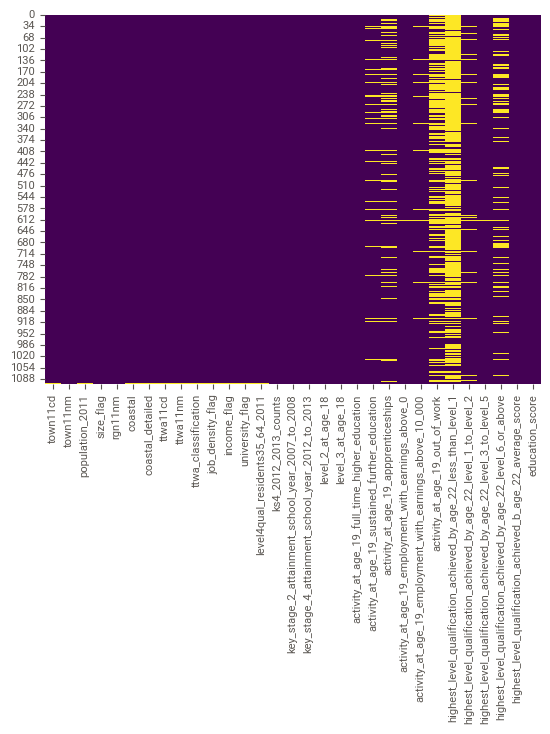

In [4]:
sns.heatmap(education.isnull(), cbar=False, cmap='viridis')
plt.show()

It seems rather clear that `highest_level_qualification_achieved_by_age_22_less_than_level_1` is not usable for modeling. We can use imputation for the other variables

For now though, for the purpose of visualisation, we'll drop missing values. We want to visualise education score as a function of town income levels and size:

In [5]:
# Drop rows where 'income_flag' is NaN
education_vis = education.dropna(subset=['income_flag'])

# Ensure proper categorical ordering for 'income_flag'
income_levels = ["Lower deprivation towns", "Mid deprivation towns", 
                 "Higher deprivation towns", "Cities"]
education_vis['income_flag'] = pd.Categorical(education_vis['income_flag'], categories=income_levels, ordered=True)

# Ensure 'size_flag' is a string (important for consistent color mapping)
education_vis['size_flag'] = education_vis['size_flag'].astype(str)

# Create the plot
p = ggplot(education_vis, aes(x='education_score', y='income_flag', fill='size_flag')) + \
    geom_boxplot(color='black',alpha=0.5) + \
    scale_fill_manual(values=['#F4C2C2', '#D5E8D4', '#B4D3E7', '#D4A3DA']) + \
    labs(x="Education score",y="",fill="")  # Y-axis label removed, legend title hidden

p

/var/folders/5s/2df7vjxs371f0f47gzlnsjg40000gp/T/ipykernel_37118/667469140.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  education_vis['income_flag'] = pd.Categorical(education_vis['income_flag'], categories=income_levels, ordered=True)
/var/folders/5s/2df7vjxs371f0f47gzlnsjg40000gp/T/ipykernel_37118/667469140.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  education_vis['size_flag'] = education_vis['size_flag'].astype(str)


## Building a regression model


**Training vs testing split**...

As we explained last week (and in [this week's lab](/2024/winter-term/weeks/week03/lab_materials/LSE_DS202W_W03_lab_roadmap.qmd)), before building a regression model (and before applying imputation), we need to split the data into training and test sets. Why do we do that?

We want our models to generalize to unseen data...What if we were to predict attainment for another of the UK countries e.g Scotland or Wales? What if we were to predict attainment for England for another year? Would the model still be valid then? We split the data into training and test data to increase the robustness of our modeling: the evaluation on the test set allows us to gain an unbiased assessment of how well our model performs on completely new, unseen data, simulates how the model would function in a real-world application and ensures the model can generalize beyond the training data and make accurate predictions on new examples; this is crucial to avoid overfitting and validate the model's true effectiveness.

To simplify things slightly, I'll remove some unnecessary data before I do my split:

- I'll remove the `highest_level_qualification_achieved_by_age_22_less_than_level_1` as it is not usable for modeling
- I'll only select numeric variables as I will only be using these in my modeling for simplicity (I could encode categorical features but I won't be doing this here)

In [6]:
education = education.drop('highest_level_qualification_achieved_by_age_22_less_than_level_1',axis=1)
education = education.select_dtypes(include=[float, int])

In [7]:
x_train, x_test, y_train, y_test = train_test_split(education.drop('education_score', axis=1), education['education_score'], random_state = 42)

By default, the `train_test_split` function in `scikit-learn` (see [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)) sets the proportions of training/test sets to 75/25% of the data respectively. Other common splits would be 70/30% and 80/20%.

Let's impute our missing values before continuing. Since all values are numeric, I can use KNN imputation here (see details [here](https://www.analyticsvidhya.com/blog/2020/07/knnimputer-a-robust-way-to-impute-missing-values-using-scikit-learn/)).

In [8]:
imputer = KNNImputer(n_neighbors= 3)
x_train_imp = imputer.fit_transform(x_train)
x_train_imp = pd.DataFrame(x_train_imp, columns=x_train.columns) # by default, KNNImputer returns an array, so you have to convert back to a Dataframe with the right column labeling
x_test_imp = imputer.fit_transform(x_test)
x_test_imp = pd.DataFrame(x_test_imp, columns=x_test.columns)



Now let me build three models: one simple linear regression model, one multivariate linear regression model and a LASSO model

**Model 1: Simple linear regression model (`population_2011` as single predictor)**

In [9]:
# Create a model instance of a linear regression
linear_model = LinearRegression()

# Fit this instance to the training set
linear_model.fit(x_train_imp[['population_2011']], y_train)


LinearRegression()

**Model 2: Multivariate Linear Regression**

In [10]:
# Create a model instance of a linear regression
linear_model2 = LinearRegression()

# Fit this instance to the training set
linear_model2.fit(x_train_imp, y_train)

LinearRegression()

**Model 3: LASSO Regression**

In [11]:
# Create a model instance of a LASSO regression
lasso_model = Lasso(alpha = 0.02)
lasso_model.fit(x_train_imp, y_train)

Lasso(alpha=0.02)

*What is the principle of LASSO?*

In standard linear regression, you're trying to find a series of coefficients $\hat{\beta_i}$ such that you minimize the following cost function: 

$L=\sum_{i=1}^n (y_i - \hat{y_i})^2=\sum_{i=1}^n (y_i - \hat{\beta_i}x_i$)^2

In LASSO, you simply add a penalty term i.e:

$L_{lasso}=\sum_{i=1}^n (y_i - \hat{\beta_i}x_i)^2 + \lambda \sum_{j=1}^m|\hat{\beta_j}|$

By choosing $\lambda$ well, you can constrain some of the coefficients to shrink to 0, effectively removing some unnecessary variables and operating feature selection.

*LASSO regression also assumes linearity of relationship between variable predicted and predictors*. 


How do we know if one model is better than another?

-   By comparing the **goodness-of-fit** of the models using standardised metrics
-   By comparing predictions of the models on a test set, **using the same unit of measurement**

## 1.1 Comparing models

Let's first have a look at train set metrics.

We could use RMSE here if we wanted (RMSE has same unit of measurement as the variable you are trying to predict!) since we're always predicting the same variable so our units would be consistent throughout . But there's one metric that is agnostic to the unit of measurement: the $R^2$ metric. We'll use $R^2$ here.

In [12]:
# Create predictions for the train set
linear_preds_train = linear_model.predict(x_train_imp[['population_2011']])

# Calculate performance metrics
r2 = r2_score(y_train, linear_preds_train)
rmse = root_mean_squared_error(y_train, linear_preds_train)
mae = mean_absolute_error(y_train, linear_preds_train)

# Print results
print("Train set metrics: The R2 metric for this model is:",np.round(r2, 2),", the MAE is", np.round(mae, 2)," and the RMSE is ", np.round(rmse, 2),"\n")

Train set metrics: The R2 metric for this model is: 0.01 , the MAE is 2.82  and the RMSE is  3.54 



In [14]:
# Create predictions for the train set
linear_preds2_train = linear_model2.predict(x_train_imp)

# Calculate performance metrics
r2 = r2_score(y_train, linear_preds2_train)
rmse = root_mean_squared_error(y_train, linear_preds2_train)
mae = mean_absolute_error(y_train, linear_preds2_train)

# Print results
print("Train set metrics: The R2 metric for this model is:",np.round(r2, 3),", the MAE is", np.round(mae, 3)," and the RMSE is ", np.round(rmse, 3),"\n")

Train set metrics: The R2 metric for this model is: 1.0 , the MAE is 0.005  and the RMSE is  0.026 



In [15]:
# Create predictions for the train set
lasso_preds_train = lasso_model.predict(x_train_imp)

# Calculate performance metrics
r2_lasso = r2_score(y_train, lasso_preds_train)
rmse_lasso = root_mean_squared_error(y_train, lasso_preds_train)
mae_lasso = mean_absolute_error(y_train, lasso_preds_train)

# Print results
print("Train set metrics: The R2 metric for this model is:",np.round(r2_lasso, 3),", the MAE is", np.round(mae_lasso, 3)," and the RMSE is ", np.round(rmse_lasso, 3),"\n")

Train set metrics: The R2 metric for this model is: 0.996 , the MAE is 0.164  and the RMSE is  0.221 



|Model|R^2|MAE|RMSE|
|-----|---|---|----|
| Simple linear regression| 0.01| 2.83|3.54|
| Multivariate linear regression|1.0|0.0|0.03|
|LASSO|1.0|0.16|0.22|

## 1.2 $R^2$ as a measures of goodness-of-fit

When you were asked to calculate, for example, the RMSE or MAE of a model when applied to the training set, you were calculating the goodness-of-fit.

> 📕 Goodness-of-fit is the concept of how well a model fits the data it was trained on.

The RMSE and MAE have the same unit of measurement as the variable you are trying to predict, but there are some measures that are agnostic to the unit of measurement and it might be useful to know them.

The R-squared metric uses the concept of residuals, which you have explored in the previous weeks. The $R^2$ metric is defined as:

$$
R^2 = 1 - \frac{RSS}{TSS}
$$

where $RSS = \sum_{i=1}^n (y_i - \hat{y}_i)^2$ (the sum of squares of the residuals) and $TSS = \sum_{i=1}^n (y_i - \bar{y})^2$ is the total sum of squares of all the data points used to fit the model [^1]. The closer $R^2$ is to 1, the better the model *explains the variance* in the data. The closer it is to 0, the worse the model is.

[^1]: See [An Introduction to Statistical Learning with Applications in Pythin](https://www.statlearning.com/) by James et al. Page 79 (freely available online).

The $R^2$ metric is closely related to the Pearson correlation coefficient ($\rho$):

$$
\rho = \sqrt{R^2}
$$

where $\rho$ is the Pearson correlation coefficient.

The interpretation is a little different: $\rho$ ranges from -1 to 1. Values of $|\rho|$ closer to 1 indicate that the two variables are more strongly **linearly correlated**. Values of $|\rho|$ closer to 0 indicate that the two variables are less strongly **linearly correlated**.

In [ ]:
# Pandas method corr returns the Pearson correlation coefficient
y_train.corr(x_train_imp['population_2011'])

Note though that the Pearson coefficient only applies to numerical variables.

## ⚠️ Note on Metrics and Non-Linearity:

These two metrics are only useful in the context of linear models. It is definitely possible for two variables to be strongly associated with each other but in a *non-linear* way. Think of studying and exam scores: more studying leads to better scores, but only to a point (diminishing returns).

For now, we use $$R^2$$ to compare `linear_model`, `linear_model2` and `lasso_model` in a **linear context**. While not absolute proof ("all models are wrong, but some are useful"), **model2** seems superior based on these measures.

But *'How do I know **for sure**'*, I hear you ask? To more robustly assess performance, let's test all three models on unseen data using a **test set**. That's our next step!

⚠️ **WARNING:** R-squared [will always improve](https://lse-dsi.github.io/lse-ds202-course-notes/blog/posts/r-squared.html) if you add more predictors, even if the predictors are random. So, if you are comparing models with different predictors, use the adjusted R-squared instead.

# 2. Don't stick just to goodness-of-fit, though, go deeper

It is very easy to conclude by looking at measures of goodness-of-fit that `linear_model2` and `lasso_model` are superior to `linear_model`. It is true that the two last models look like better a linear fits (and also more informative ones). However, what I want you to remember when comparing different models is the following:

> *All models are wrong, but just how useful are these models?*

## 2.1 Why use a test set?

The whole point of having a test set is to check if our model is as good as it sounds on paper. We want our models to be useful in the real world, not just when used on the training data.

Thinking this way, let's compare the predictions made by our models and although I could still continue to compare them with unit-agnostic measures like $R^2$, I want to bring you back to the RMSE/MAE - it will be easier to interpret and make it more 'real-world'.

Predictions made by `linear_model` are already made in the scale of the predicted education score (a numeric score from -10 to 10 without unit):

In [16]:
# Create predictions for the test set
linear_preds = linear_model.predict(x_test_imp[['population_2011']])

# Calculate performance metrics
r2 = r2_score(y_test, linear_preds)
rmse = root_mean_squared_error(y_test, linear_preds)
mae = mean_absolute_error(y_test, linear_preds)

# Print results
print("Test set metrics: The R2 metric for this model is:",np.round(r2, 2),", the MAE is", np.round(mae, 2)," and the RMSE is ", np.round(rmse, 2),"\n")

Test set metrics: The R2 metric for this model is: 0.01 , the MAE is 2.97  and the RMSE is  3.74 



The predictions made by `linear_model2` are also made in the same scale and units:

In [18]:
# Create predictions for the test set
linear_preds2 = linear_model2.predict(x_test_imp)

# Calculate performance metrics
r2 = r2_score(y_test, linear_preds2)
rmse = root_mean_squared_error(y_test, linear_preds2)
mae = mean_absolute_error(y_test, linear_preds2)

# Print results
print("Test set metrics: The R2 metric for this model is:",np.round(r2, 3),", the MAE is", np.round(mae, 3)," and the RMSE is ", np.round(rmse, 3),"\n")

Test set metrics: The R2 metric for this model is: 1.0 , the MAE is 0.003  and the RMSE is  0.005 



The same can be said for `lasso_model` :

In [19]:
# Create predictions for the test set
lasso_preds = lasso_model.predict(x_test_imp)

# Calculate performance metrics
r2_lasso = r2_score(y_test, lasso_preds)
rmse_lasso = root_mean_squared_error(y_test, lasso_preds)
mae_lasso = mean_absolute_error(y_test, lasso_preds)

# Print results
print("Test set metrics: The R2 metric for this model is:",np.round(r2_lasso, 3),", the MAE is", np.round(mae_lasso, 3)," and the RMSE is ", np.round(rmse_lasso, 3),"\n")

Test set metrics: The R2 metric for this model is: 0.995 , the MAE is 0.175  and the RMSE is  0.268 



|Model|R^2|MAE|RMSE|
|-----|---|---|----|
| Simple linear regression| 0.01| 2.97|3.74|
| Multivariate linear regression|1.0|0.0|0.01|
|LASSO|0.99|0.18|0.27|

On the basis of the metrics above, the best performing model seems to be the multivariate linear regression but is it really?

## 2.2 Residuals plot (on test set)

### 2.2.1 Easy to do for `linear_model`

In [20]:
residuals = y_train - linear_preds_train

residuals_df = pd.DataFrame({
    'Predicted': linear_preds_train,
    'Residuals': residuals
})

# Plot using Lets-Plot
ggplot(residuals_df) + \
    geom_point(aes(x='Predicted', y='Residuals')) + \
    geom_hline(yintercept=0, color='red', size=1) + \
    ggtitle('Residuals Plot for Linear Regression') + \
    xlab('Predicted values') + \
    ylab('Residuals')

### 2.2.2 Same work for the other models

Let's create the residuals plot for `linear_model2` now.

In [21]:
residuals2 = y_train - linear_preds2_train

residuals2_df = pd.DataFrame({
    'Predicted': linear_preds2_train,
    'Residuals': residuals2
})

# Plot using Lets-Plot
ggplot(residuals2_df) + \
    geom_point(aes(x='Predicted', y='Residuals')) + \
    geom_hline(yintercept=0, color='red', size=1) + \
    ggtitle('Residuals Plot for Linear Regression') + \
    xlab('Predicted values') + \
    ylab('Residuals')

Then, let's create the residuals plot but `lasso_model` now.

In [22]:
residuals_lasso = y_train - lasso_preds_train

residuals_lasso_df = pd.DataFrame({
    'Predicted': lasso_preds_train,
    'Residuals': residuals_lasso
})

# Plot using Lets-Plot
ggplot(residuals_lasso_df) + \
    geom_point(aes(x='Predicted', y='Residuals')) + \
    geom_hline(yintercept=0, color='red', size=1) + \
    ggtitle('Residuals Plot for LASSO Regression') + \
    xlab('Predicted values') + \
    ylab('Residuals')


### 2.3.2 MAPE

RMSE and MAE are already normalized and provids a way to compare the usual fluctuations of your predicted variable (e.g in this case the usual fluctations i.e variance (for RMSE) or absolute mean difference (for MAE) of the educational attainment score). Another one is MAPE or Mean Absolute Percentage Error. MAPE is the average absolute percentage difference between predicted values and actual values. Basically, a MAPE value of 20% means that the average absolute percentage difference between the predictions and the true values is 20%.

There is a handy `scikit-learn.metrics` metrics function called `mean_absolute_percentage_error`(see [here](https://scikit-learn.org/stable/modules/model_evaluation.html) for the various available evaluation metrics) to calculate this for us, but the equation is as follows:

$$
\text{MAPE} = \frac{1}{n}\sum_{i=1}^n{\left|\frac{y_i - \hat{y_i}}{y_i}\right|}
$$

That is: on average, how much does the residual differs from the actual baseline value?

In [26]:
mape_linear_model=mean_absolute_percentage_error(y_test,linear_preds)
mape_linear_model2=mean_absolute_percentage_error(y_test,linear_preds2)
mape_lasso=mean_absolute_percentage_error(y_test, lasso_preds)
print("MAPE for linear_model is", np.round(mape_linear_model,2), "\nMAPE for linear_model2 is", np.round(mape_linear_model,2),"\nMAPE for lasso_model is", np.round(mape_lasso,2))

MAPE for linear_model is 1.25 
MAPE for linear_model2 is 1.25 
MAPE for lasso_model is 0.59


Here, `linear_model` and `linear_model2` are tied at 1.25. `lasso_model` wins here.


## Another look at LASSO

The principle of LASSO is that it shrinks irrelevant coefficients to 0.

Let's first get the coefficients obtained through the LASSO model and let's sort them by order of (absolute) magnitude.

In [27]:
lasso_output = pd.DataFrame({"feature": x_train_imp.columns, "coefficient": lasso_model.coef_})

# Code a positive / negative vector
lasso_output["positive"] = np.where(lasso_output["coefficient"] >= 0, True, False)

# Take the absolute value of the coefficients
lasso_output["coefficient"] = np.abs(lasso_output["coefficient"])

# Remove the constant and sort the data frame by (absolute) coefficient magnitude
lasso_output = lasso_output.query("feature != 'const'").sort_values("coefficient")

Now, let's plot those coefficients and see which ones have shrunk to 0.

In [28]:
(
  ggplot(lasso_output, aes("coefficient", "feature", fill = "positive")) +
  geom_bar(stat = "identity") +
  theme(panel_grid_major_y = element_blank()) +
  labs(x = "Lasso coefficient", y = "Feature",
       fill = "Positive?")
)

Now, which model do you think is best? Why?

# 4. Classification: a different type of supervised learning model

## 4.1 Making binary predictions

Now say I have a brand new ambition: to predict whether towns have an educational attainment score that is positive or not (`Yes` or `No`). 

Allow me to start over with my pre-processing and to create a target variable `education_score_positive`. I'll directly encode `Yes` as 1 and `No` as 0.

In [29]:
education['education_score_positive'] = (education['education_score'] >= 0).astype(int)

As before, let's split our data in training/test set:

In [30]:
x_train_classif, x_test_classif, y_train_classif, y_test_classif = train_test_split(education.drop('education_score_positive', axis=1), education['education_score_positive'], random_state = 42)

And our imputation:

In [31]:
imputer = KNNImputer(n_neighbors= 3)
x_train_classif_imp = imputer.fit_transform(x_train_classif)
x_train_classif_imp = pd.DataFrame(x_train_classif_imp, columns=x_train_classif.columns) # by default, KNNImputer returns an array, so you have to convert back to a Dataframe with the right column labeling
x_test_classif_imp = imputer.fit_transform(x_test_classif)
x_test_classif_imp = pd.DataFrame(x_test_classif_imp, columns=x_test_classif.columns)

Let's quickly tally of many of each class of education attainment score we have

In [32]:
# Tally the number of 0s and 1s in the 'education_score_positive' column
tally = education['education_score_positive'].value_counts()

# Calculate the percentages
percentages = (tally / tally.sum()) * 100

# Combine both the count and percentage into a DataFrame
tally_df = pd.DataFrame({
    'count': tally,
    'percentage': percentages
})

# Print the result nicely
print("Tally with Counts and Percentages of education_score_positive column:")
print(tally_df)

Tally with Counts and Percentages of education_score_positive column:
                          count  percentage
education_score_positive                   
0                           595   53.894928
1                           509   46.105072


Some slightly class imbalance (there are a few more towns with negative educational attainment scores) but the imbalance is not massive.

OK, but how do I write a model for the `education_score_positive` variable?

## 4.2 Could I do linear regression?

In theory, yes, but only if you convert the `Yes` and `No` **labels** to numbers. Say: 1 and 0, respectively.

In [33]:
model_yes_no = LinearRegression()
model_yes_no.fit(x_train_classif_imp[['population_2011']], y_train_classif)

LinearRegression()

What does this mean? Well, since linear regression is a **regression** algorithm, i.e., it operates on numbers, I can do as before and plot the predictions versus the actual values:

In [34]:
y_pred_model_yes_no = model_yes_no.predict(x_test_classif_imp[['population_2011']])
residuals_yes_no = y_test_classif - y_pred_model_yes_no
residuals_df_yes_no = pd.DataFrame({
    'population_2011': x_test_classif_imp['population_2011'],
    'residuals': residuals_yes_no
})
ggplot(residuals_df_yes_no, aes(x='population_2011', y='residuals')) + \
    geom_point() + \
    labs(title='Residuals Plot', x='Population 2011', y='Residuals')

NO. Linear Regression is not suitable for predicting labels. It would be more useful if we were to predict **probabilities** instead of single numbers.

## 4.3. Logistic Regression

Consider a **binary** response:

$$
Y = \begin{cases}
0 \\
1
\end{cases}
$$

We model the probability that $Y = 1$ using the **logistic function** (aka. sigmoid curve):

$$
Pr(Y = 1|X) = p(X) = \frac{e^{\beta_0 + \beta_1X}}{1 + e^{\beta_0 + \beta_1 X}}
$$

This function is mathematically guaranteed to be bounded by the interval $[0, 1]$.

### 4.3.1 Insight into the logistic function

Let's see how this mathematical function looks like:

In [35]:
def plot_logistic_function(X_range, beta0_values, beta1_values, color=None):
    # Create a dataframe similar to expand.grid() in R
    df = pd.DataFrame(
        [(X, beta0, beta1) for X in X_range for beta0 in beta0_values for beta1 in beta1_values],
        columns=['X', 'beta0', 'beta1']
    )

    # Compute logistic function
    df['Y'] = np.exp(df['beta0'] + df['beta1'] * df['X']) / (1 + np.exp(df['beta0'] + df['beta1'] * df['X']))

    # Convert to categorical for ordered factors
    df['beta0'] = df['beta0'].astype(str)
    df['beta1'] = df['beta1'].astype(str)

    # Choose color mapping
    if color is None:
        p = ggplot(df, aes(x='X', y='Y'))
    elif color == "beta0":
        p = ggplot(df, aes(x='X', y='Y', color='beta0', linetype='beta0'))
    else:
        p = ggplot(df, aes(x='X', y='Y', color='beta1', linetype='beta1'))

    # Add lines and customize appearance
    p += geom_line(size=1.4) + \
        ggsize(800, 400) + \
        labs(x="X", y="Y") + \
        theme(panel_grid_minor='blank') + \
        theme(axis_title=element_text(size=24), 
              axis_text=element_text(size=18), 
              legend_text=element_text(size=18),
              legend_position="right")

    return p


In [37]:
X_range = np.linspace(-400, 400, 100)
beta0_values = [-3, 0, 1]
beta1_values = [1, 1, 1]
p=plot_logistic_function(X_range, beta0_values, beta1_values, color="beta1")
p+=ggtitle("If I keep beta1 constant and equal to 1 and vary beta0")

p

In [38]:
X_range = np.linspace(-4, 4, 100)
beta0_values = [0, 0, 0, 0]
beta1_values = [-1, 0, 1, 2]

p=plot_logistic_function(X_range, beta0_values, beta1_values, color="beta1")
p+=ggtitle("If I keep beta0 constant and equal to 0 and vary beta1")
p

### 4.3.2 Building a model

Again, we use `scikit-learn` to implement the logisctic regression model. The syntax is remarkably similar to linear regression. Note though that you're specifying a `random_state` parameter to ensure the reproducibility of your modeling (you're caculating probabilities here!).

That is, something like:

In [39]:
logreg = LogisticRegression(random_state=16)

Because `population_2011` is on a different scale than the variable predicted, we might have underflow issues, so we scale the variable first:

In [41]:
scaler = StandardScaler()
x_train_classif_imp[['population_2011']] = scaler.fit_transform(x_train_classif_imp[['population_2011']])
x_test_classif[['population_2011']] = scaler.transform(x_test_classif[['population_2011']])

In [42]:
logreg.fit(x_train_classif_imp[['population_2011']],y_train_classif)

y_pred_classif = logreg.predict(x_test_classif[['population_2011']])

It worked! And the code once again is quite similar to that of a linear regression.

How do we evaluate this?

*Logistic regression predicts the probability that an observation belongs to the class of towns where educational attainment score is higher than 0. To go from this probability to the class a threshold is neeeded: by default, it is 0.5 i.e if the probability of the observation belonging to the class of towns where educational attainment score is higher than 0 is higher than 0.5 then the observation falls within the class (i.e it's assigned a value of 1) and otherwise it belongs to the other class (i.e it's assigned a value of 0).* 


**Confusion matrix**

In [43]:
cnf_matrix=confusion_matrix(y_test_classif, y_pred_classif)
cnf_matrix

array([[151,   0],
       [125,   0]])

In [44]:
df = pd.DataFrame([(i, j, cnf_matrix[i, j]) for i in range(2) for j in range(2)],
                  columns=['Actual', 'Predicted', 'Count'])

# Create the heatmap
p = (ggplot(df, aes(x='Predicted', y='Actual', fill='Count')) +
     geom_tile() +
     geom_text(aes(label='Count'), size=15, color='black') +  # Annotations
     scale_fill_gradient(low="lightblue", high="darkblue") +  # Color gradient
     ggtitle("Confusion Matrix") +
     xlab("Predicted Label") +
     ylab("Actual Label") +
     theme_minimal())

p

A **confusion matrix** represents counts from predicted and actual values.

Perhaps, a bit of vocabulary to know in the context of binary classification:

-   the two classes in your classification are called positive class (i.e the class you're interested in, here developers with more than ten years' experience), and negative class

-   knowing that, you define true positives (TP) as the instances in your dataset that are of the positive class and are correctly classified by the model as belonging to the positive class, true negatives (TN) are the instances that are of the negative class and are correctly predicted by the model as belonging to the negative class, false positives (FP) are instances of the negative class that are misclassified by the model as instances of the positive class and false negatives (FN) are instances of the positive class that are falsely predicted by the model as belonging to the negative class

-   whether the FN or FP count is more important depends on your application

I have several columns that relate to predictions!

In [45]:
print(classification_report(y_test_classif, y_pred_classif,target_names=['education_score_negative','education_score_positive']))

                          precision    recall  f1-score   support

education_score_negative       0.55      1.00      0.71       151
education_score_positive       0.00      0.00      0.00       125

                accuracy                           0.55       276
               macro avg       0.27      0.50      0.35       276
            weighted avg       0.30      0.55      0.39       276



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


-   Accuracy

    It's the proportion of correct predictions i.e

    $$
    \begin{equation}
    accuracy = \frac{TP+TN}{P+N}\
    \end{equation}
    $$

    where $P$ is the total number of positive instances in the dataset and $N$ the total number of negative instances in the dataset.

    It's only a good metric when the classes within your dataset are balanced. Can you guess what the problem might be in case of imbalance?

We checked for it earlier and found there was a mild class imbalance. Accuracy could still work here, though you might be better off with other metrics.

-   Precision, recall/sensitivity and F1-score

    Precision is the proportion of true positives among all the predicted positive cases.

    $$
    \begin{align}
    precision &= \frac{TP}{TP+FP}\\
              &= \frac{TP}{\textrm{all predicted positives}}
    \end{align}
    $$

    It is a good metric when the cost of false positives is high, e.g spam detection (the consequences of misclassifying a legitimate email as spam can be significant as it may result in important communications being filtered out and so the cost of a false positive is higher than that of a false negative in this case).

    Recall (or sensitivity) is the proportion of true positives among all actual positive cases.

    $$
    \begin{align}
    recall &= \frac{TP}{TP+FN}\\
              &= \frac{TP}{\textrm{all actual positives}}
    \end{align}
    $$

    High recall is critical in applications where the cost of false negatives is high, e.g medical applications. If you think back to this week's lab, a false negative meant a patient that had diabetes being misdiagnosed as being healthy resulting in delayed diagnosis and delayed appropriate treatment (and likely deterioration of the patient's condition in the meanwhile).

    Most applications, though, will need a balance between precision and recall. That's where the F-score (especially in the form of the balanced F1-score) comes in: it's the harmonic mean of precision and recall.

    $$
    \textrm{F1-score}=2\frac{precision * recall}{precision + recall}
    $$

    A more general score $F_\beta$ exists if you want to emphasize precision over recall or vice versa:

    $$
    \textrm{F}_{\beta}\textrm{-score} = (1+\beta^2)\frac{precision * recall}{(\beta^2.precision)+ recall}
    $$

-   Specificity

    The specificity is the proportion of negatives that are correctly identified as negatives.

    $$
    specificity = \frac{TN}{TN+FP}
    $$

    It is important in contexts where the classification of negatives is of high priority.

    It's particularly useful in the medical context. Consider the example of a medical test for diagnosing a disease; e.g the HbA1C blood test used to diagnose diabetes. Specificity refers to the test's ability to correctly reject healthy patients without the condition (i.e without diabetes). Supposing HbA1C had high specificity, a positive result in such test with high specificity would be useful for "ruling in" disease, i.e determining that the patient does in fact have diabetes, since the test rarely gives positive results in healthy patients.

-   Balanced accuracy

    But specificity is also used in another context. It is one of the components used to define balanced accuracy, a metric designed to overcome the problem that accuracy has when it comes to imbalanced data.

    $$
    \begin{equation}
    \textrm{balanced}\_\textrm{accuracy}= \frac{sensitivity+specificity}{2}
    \end{equation}
    $$

The closer the balanced accuracy is to 1, the better the model is able to correctly classify observations (for both classes)


# What's Next

In the lab next week, you will be tasked with creating a logistic regression and more...We'll explore logistic regression a bit further (what do those logistic regression coefficients mean?) and look a bit closer into how classification tasks are evaluated.